In [1]:
import jax
import optax
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel.experimental.optim as opt
import liesel.goose as gs
import liesel.model as lsl

We take a super simple Liesel model here

In [2]:
xval = 2.0 * jax.random.normal(jax.random.key(42), (600,)) + 3.0

m = lsl.Var.new_param(0.0, name="m")
s = lsl.Var.new_param(1.0, name="s")
s.transform(tfb.Exp())
x = lsl.Var.new_obs(
    xval,
    distribution=lsl.Dist(tfd.Normal, loc=m, scale=s),
    name="x",
)
p = lsl.Model([x])

Next, we create a train/validation/test split of the data.

In [3]:
split = opt.Split(
    position_keys=["x"],
    n=x.value.size,  # full size of the axis along which we split
    share_validation=0.1,
    share_test=0.0,  # I don't use any test data in this example
    # -
    # if different positions are to be split along different axes, a dict
    # can be supplied here that maps the variable names to the axis
    axes=None,
    # -
    # By default, the split is conducted along axis 0. But the default axis for all
    # variables that are to be split can be changed here.
    default_axis=0,
)

# By default, opt.Split does not randomize the order of the data.
# That can be done manually.
split.indices = split.permute_indices(jax.random.key(4))

# Finally, we apply the split by passing a model and its state.
data = split.split_state(p, p.state)

Next, we prepare batching.

In [19]:
bi = opt.Batches(
    position_keys=["x"],
    n=data.n_train,  # full size of the training data set.
    batch_size=5,
    shuffle=True,  # can be set to turn off shuffling in Batches.permute_indices
    # -
    # if different positions are to be split along different axes, a dict
    # can be supplied here that maps the variable names to the axis
    axes=None,
    # -
    # By default, the split is conducted along axis 0. But the default axis for all
    # variables that are to be split can be changed here.
    default_axis=0,
)

Now we build the  variational distribution.
Here, we used two independent Gaussian distributions for the parameters.

In [20]:
q1 = opt.VDist(["m"], p).mvn_diag()
q2 = opt.VDist(["s_transformed"], p).mvn_diag()
vi_dist = opt.CompositeVDist(q1, q2).build()
parameters = vi_dist.parameters

Next, we initialize our loss object.

In [21]:
loss = opt.Elbo.new(vi_dist, data, nsamples=10, scale=True, nsamples_validation=30)

Next, we initialize the optimizer.

In [22]:
optim = opt.Optimizer(parameters, optimizer=optax.adam(learning_rate=1e-2))

Next, we initialize the engine.

In [23]:
engine = opt.OptimEngine(
    loss=loss,
    batching_indices=bi,
    data=data,
    optimizers=[optim],
    stopper=opt.Stopper(max_iter=1000, patience=50, atol=0.0, rtol=1e-4),
    seed=42,
    restore_best_position=True,
    prune_history=True,
    show_progress=True,
    save_position_history=True,
    progress_n_updates=100,
)

Finally, we run the optimization.

In [24]:
result = engine.fit()

Training loss: 2.080, Validation loss: 2.098:  17%|█▋        | 172/1000 [00:01<00:05, 146.97it/s]


Now we can inspect the loss and parameter history.

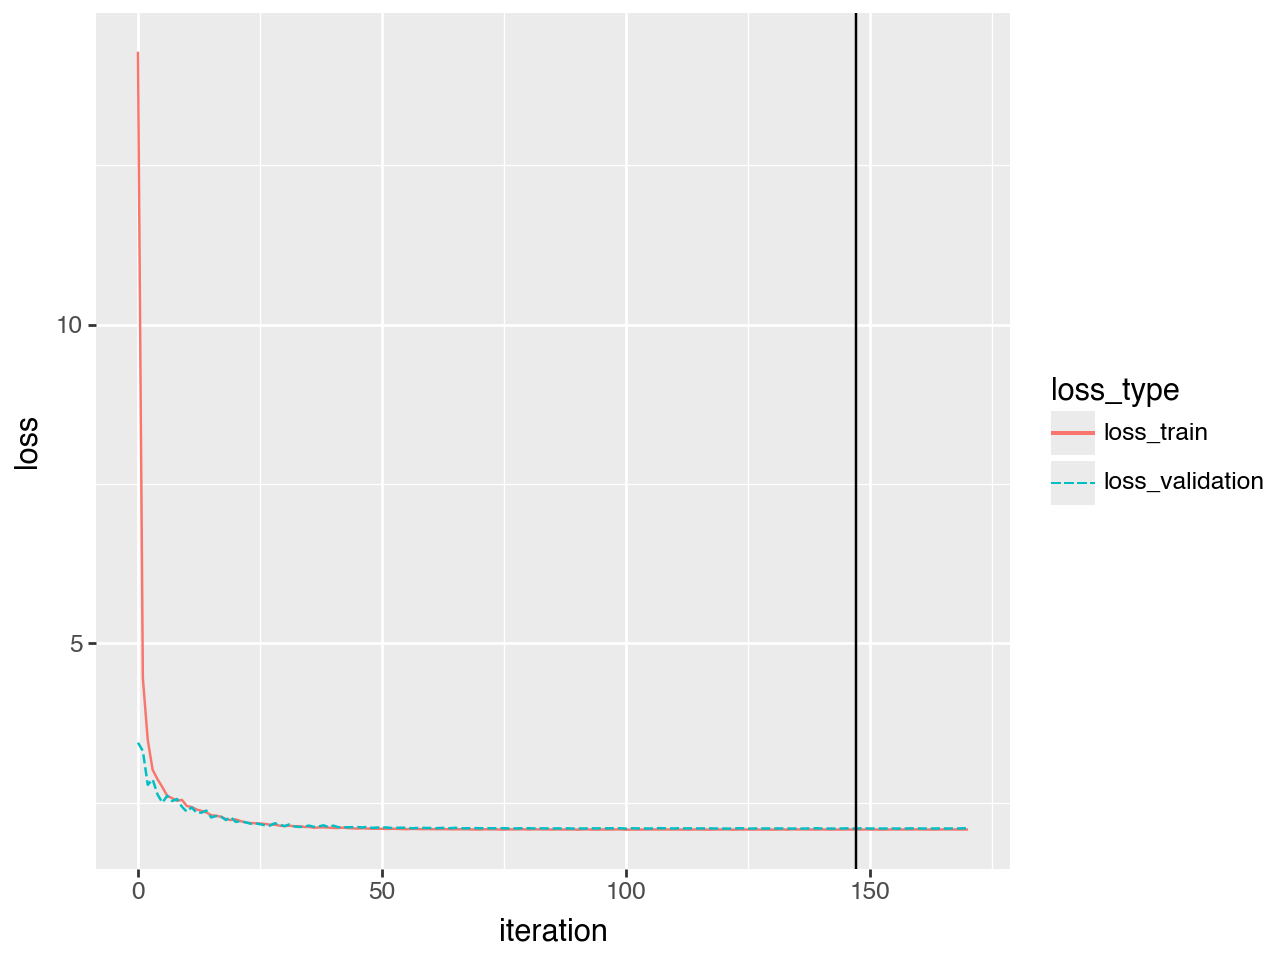

In [25]:
result.plot_loss()

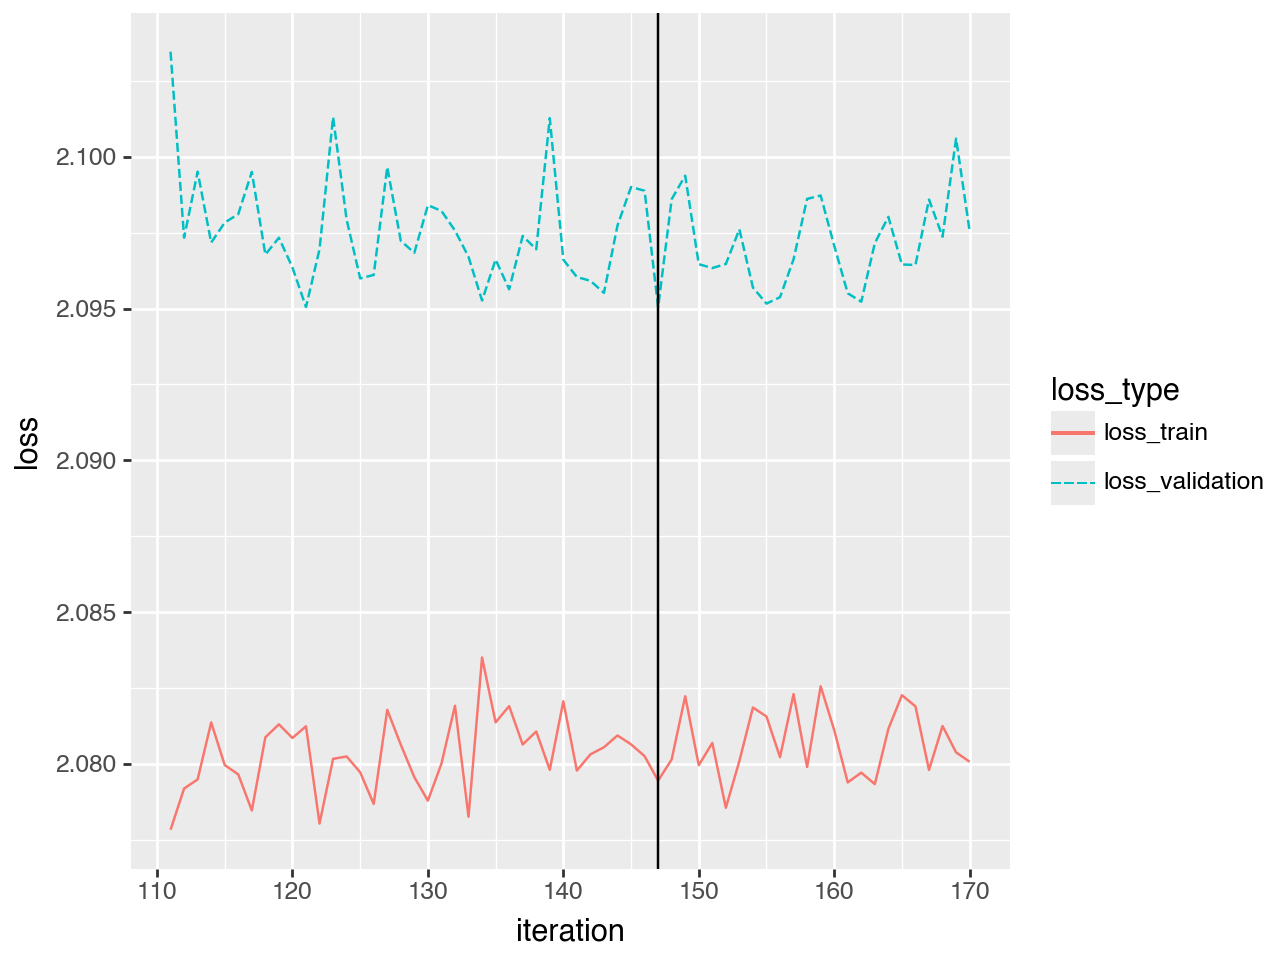

In [27]:
result.plot_loss(window=60)

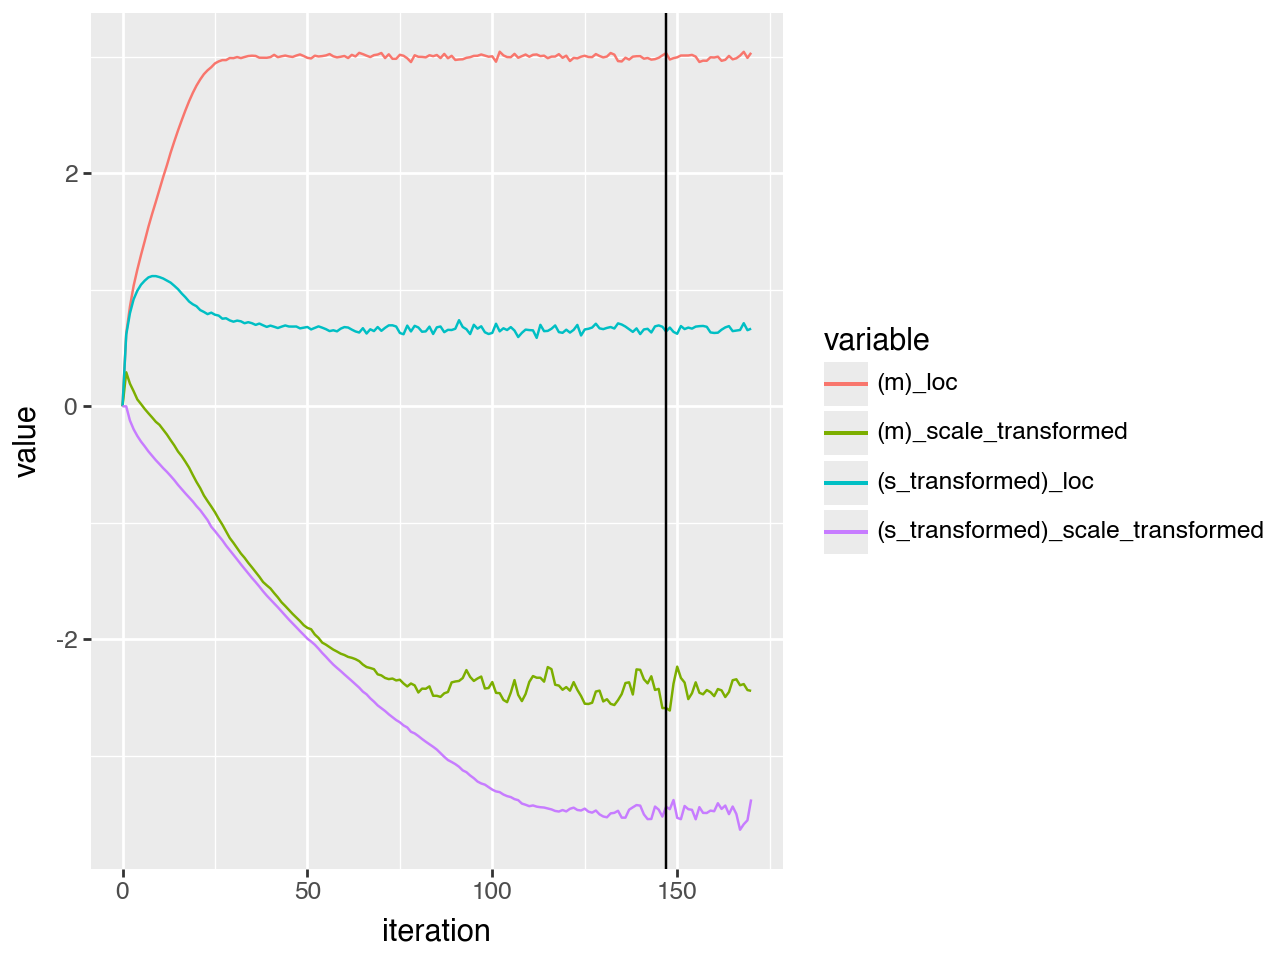

In [28]:
result.plot_param_history()

For VI, we can now sample from the variational distribution and translate these samples
into samples into a form that is easily usable as an approximation to the posterior.
We can then use the existing goose functionality to summarize the samples, etc.

In [29]:
p_samples = vi_dist.sample_p(
    n=1000, seed=jax.random.key(42), prepend_axis=True, at_position=result.best_position
)

# add samples of the actual quantity of interest
s_samples = p.predict(p_samples, predict=["s"])
summary = gs.SamplesSummary(p_samples | s_samples)
summary.to_dataframe()

,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
variable,,,,,,,,,,,,,,,
m,m,(),1000,3.027968,0.005212,0.072194,1024.328810,888.472219,0.002264,0.001642,2.912188,3.025253,3.147368,2.924578,3.156641
s,s,(),1000,1.899551,0.003547,0.059553,912.325662,933.537162,0.001981,0.001359,1.804115,1.897978,2.002216,1.804135,2.002301
s_transformed,s_transformed,(),1000,0.641127,0.000980,0.031311,912.325662,933.537162,0.001039,0.000710,0.590070,0.640789,0.694255,0.590081,0.694297


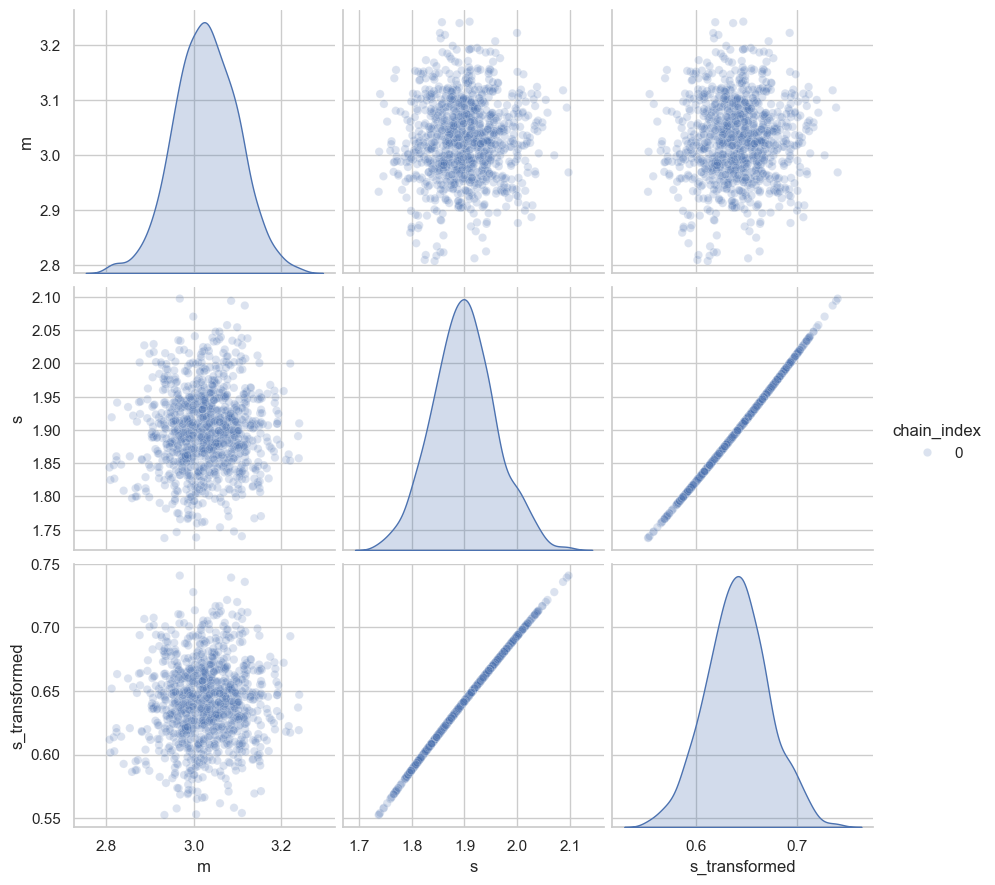

In [30]:
gs.plot_pairs(p_samples | s_samples)

## Variations

### One combined variational dist

In [14]:
vi_dist = opt.VDist(["m", "s_transformed"], p).mvn_diag()

### Custom variational dist

In [15]:
q1 = opt.VDist(["m"], p).mvn_diag()

dist_s_transformed = lsl.Dist(
    tfd.LogNormal,
    loc=lsl.Var.new_param(0.0, name="(s_transformed)_loc"),
    scale=lsl.Var.new_param(1.0, name="(s_transformed)_scale"),
)
dist_s_transformed["scale"].transform(tfb.Softplus())

# VDist.init takes any liesel distribution
q2 = opt.VDist(["s_transformed"], p).init(dist=dist_s_transformed)

vi_dist = opt.CompositeVDist(q1, q2).build()
parameters = vi_dist.parameters

### Blocked optimizers

In [16]:
opt1 = opt.Optimizer(q1.parameters, optimizer=optax.adam(learning_rate=1e-2))
opt2 = opt.Optimizer(q2.parameters, optimizer=optax.adam(learning_rate=1e-5))
optimizers = [opt1, opt2]